<a href="https://colab.research.google.com/github/DeepanIsCool/COMSYS2025-SOLYRIX/blob/main/COMSYS_2025_TASK_A_SOLYRIX_0_9408.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMSYS 2025 TASK A BY TEAM SOLYRIX**

In [ ]:
# @title Download Dependencies & Dataset

!pip install timm tensorboardX torch-ema --quiet

!git clone https://github.com/DeepanIsCool/COMSYS2025-SOLYRIX.git

fatal: destination path 'COMSYS2025-SOLYRIX' already exists and is not an empty directory.


Using device: cuda
Class weights: tensor([3.1782, 0.5933], device='cuda:0')


/tmp/ipykernel_35/2678934880.py:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_35/2678934880.py:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1/61]   2%|1          [00:00<?]

Epoch 1 Val Acc: 0.3697, Val Loss: 0.8563


[1/61]   2%|1          [00:00<?]

Epoch 2 Val Acc: 0.9242, Val Loss: 0.2110


[1/61]   2%|1          [00:00<?]

Epoch 3 Val Acc: 0.9218, Val Loss: 0.2122


[1/61]   2%|1          [00:00<?]

Epoch 4 Val Acc: 0.9147, Val Loss: 0.2295


[1/61]   2%|1          [00:00<?]

Epoch 5 Val Acc: 0.9265, Val Loss: 0.2393


[1/61]   2%|1          [00:00<?]

Epoch 6 Val Acc: 0.9242, Val Loss: 0.2432


[1/61]   2%|1          [00:00<?]

Epoch 7 Val Acc: 0.9218, Val Loss: 0.2643


[1/61]   2%|1          [00:00<?]

Epoch 8 Val Acc: 0.9360, Val Loss: 0.2605


[1/61]   2%|1          [00:00<?]

Epoch 9 Val Acc: 0.9313, Val Loss: 0.2864


[1/61]   2%|1          [00:00<?]

Epoch 10 Val Acc: 0.9242, Val Loss: 0.2829


[1/61]   2%|1          [00:00<?]

Epoch 11 Val Acc: 0.9384, Val Loss: 0.3063


[1/61]   2%|1          [00:00<?]

Epoch 12 Val Acc: 0.9408, Val Loss: 0.3301


[1/61]   2%|1          [00:00<?]

Epoch 13 Val Acc: 0.9408, Val Loss: 0.2865


[1/61]   2%|1          [00:00<?]

Epoch 14 Val Acc: 0.9384, Val Loss: 0.3073


[1/61]   2%|1          [00:00<?]

Epoch 15 Val Acc: 0.9384, Val Loss: 0.3379


[1/61]   2%|1          [00:00<?]

Epoch 16 Val Acc: 0.9384, Val Loss: 0.3821


[1/61]   2%|1          [00:00<?]

Epoch 17 Val Acc: 0.9384, Val Loss: 0.4100


[1/61]   2%|1          [00:00<?]

2025-07-04 03:39:30,927 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 18 Val Acc: 0.9408, Val Loss: 0.4186

--- Validation Results ---
Classification Report:
               precision    recall  f1-score   support

      female       0.89      0.78      0.83        79
        male       0.95      0.98      0.96       343

    accuracy                           0.94       422
   macro avg       0.92      0.88      0.90       422
weighted avg       0.94      0.94      0.94       422



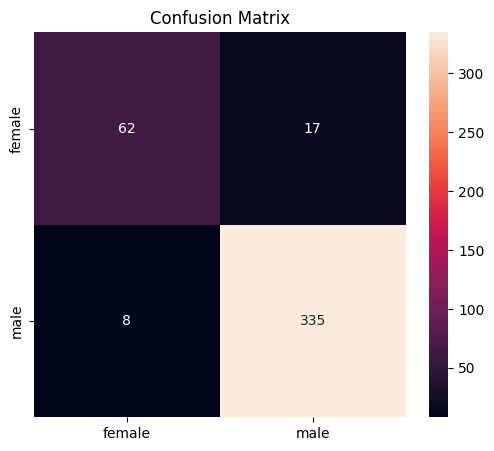

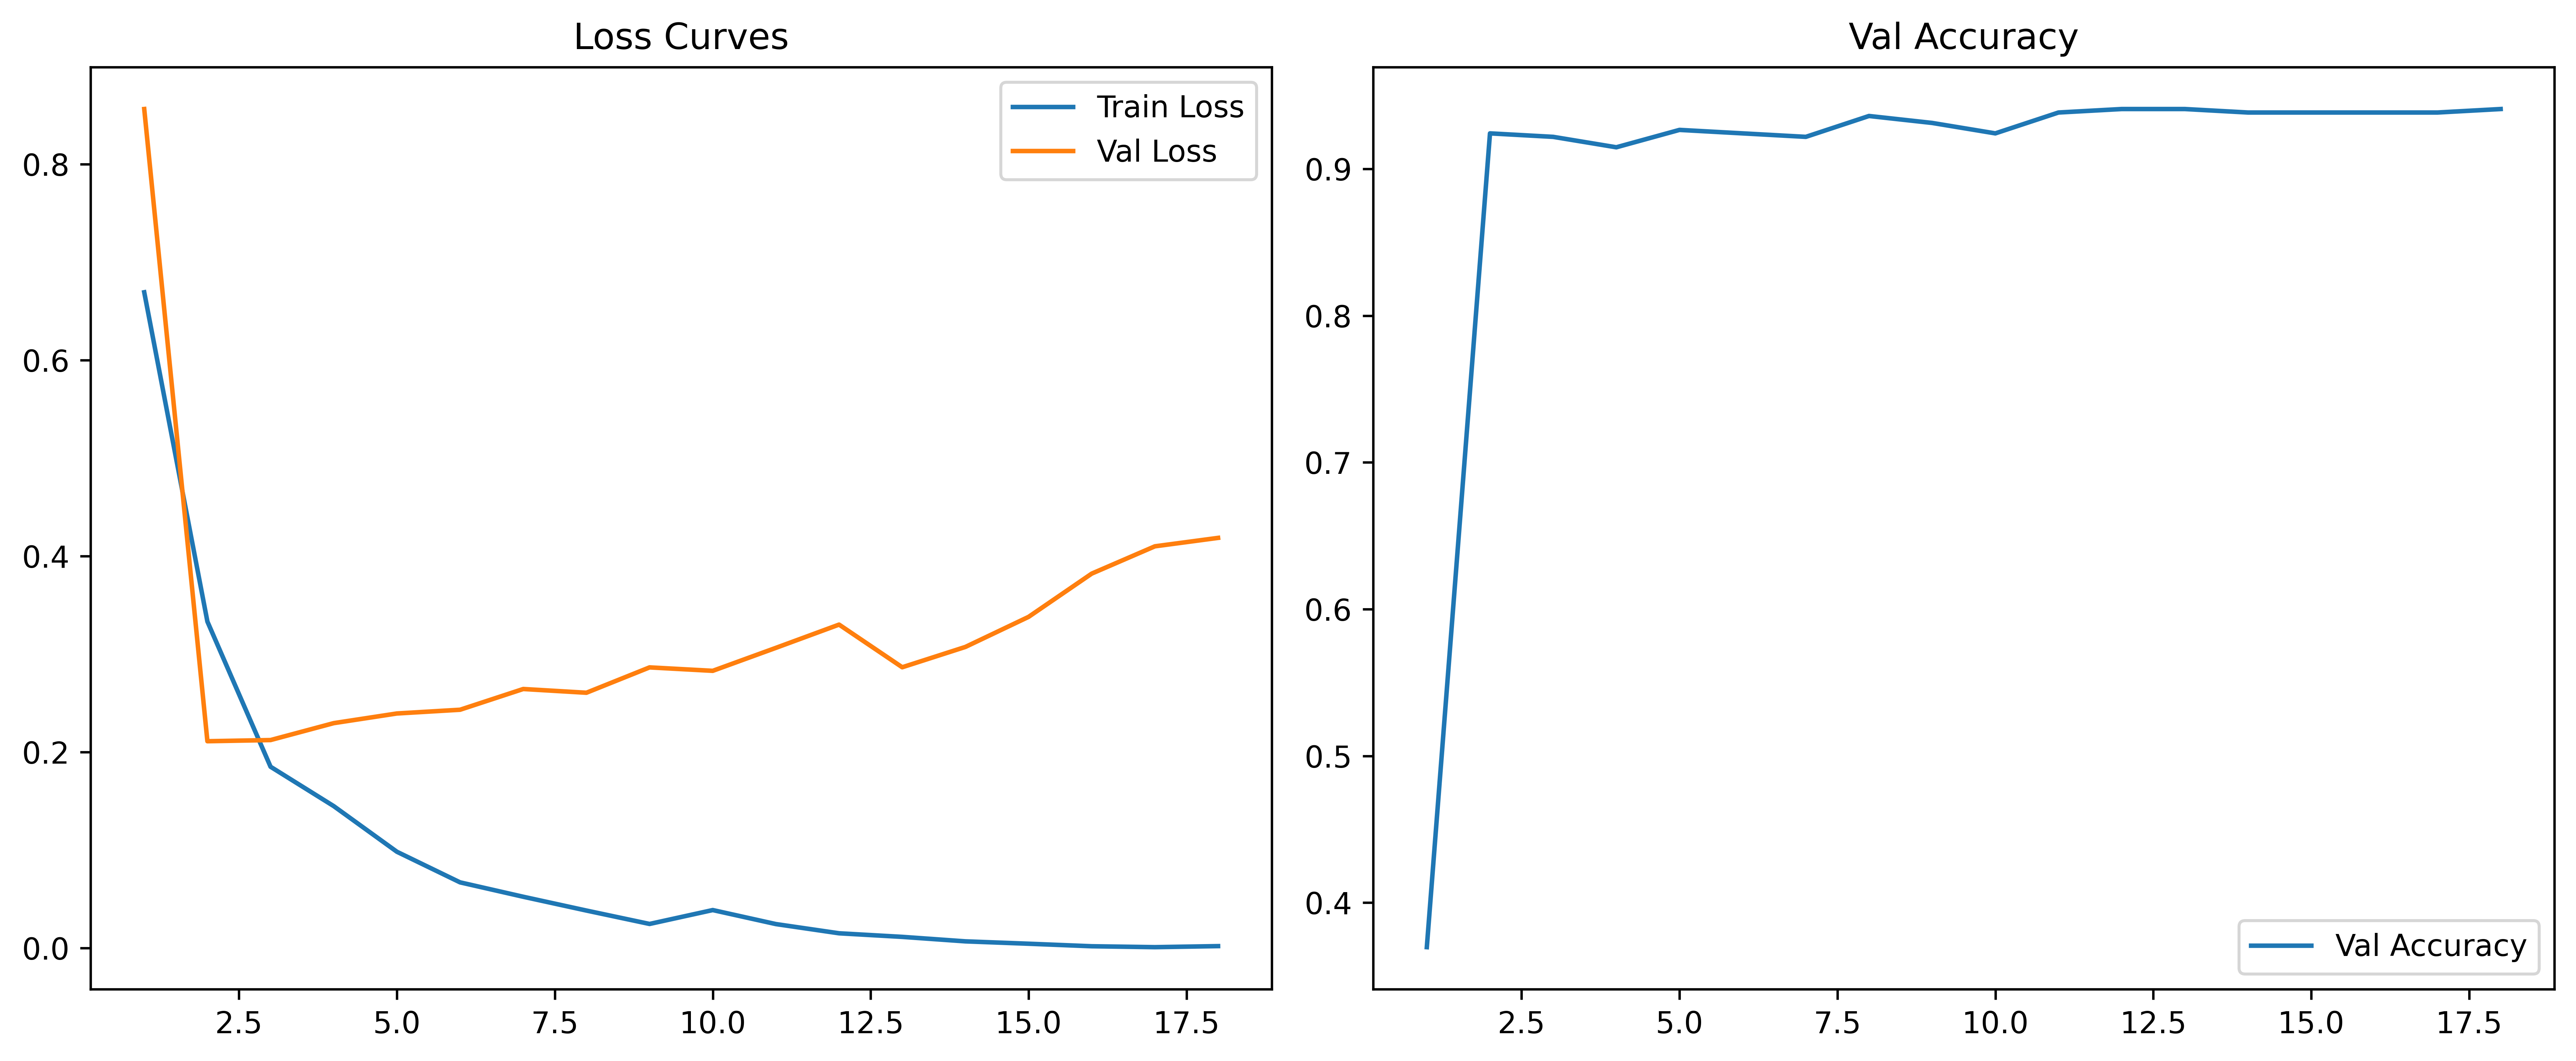

In [ ]:
# @title Main Code Block

import os, random, math, csv, gc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from sklearn.metrics import classification_report, confusion_matrix

from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Accuracy, Precision, Recall, Loss
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.handlers.tensorboard_logger import TensorboardLogger, OutputHandler, OptimizerParamsHandler
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import ProgressBar

from torch_ema import ExponentialMovingAverage

# --- Set seed, device, directories ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/kaggle/working/COMSYS2025-SOLYRIX/Dataset/Task_A"  # <-- Change to your dataset path

# --- Augmentations ---
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.25),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- Data loaders (using /train and /val folders) ---
train_ds = ImageFolder(os.path.join(data_dir, 'train'), transform=train_tf)
val_ds   = ImageFolder(os.path.join(data_dir, 'val'), transform=val_tf)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- Class weights ---
labels = [y for _, y in train_ds.samples]
counter = Counter(labels)
num_samples = sum(counter.values())
weights = [num_samples / (2 * counter[i]) for i in range(2)]
class_weights = torch.tensor(weights).float().to(device)
print("Class weights:", class_weights)

# --- Model (ConvNeXt Base, or EfficientNet B3/B4 etc.) ---
import timm
model = timm.create_model('convnext_base', pretrained=True, num_classes=2)
model.to(device)

# --- Model EMA ---
ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

# --- Loss, Optimizer, LR Scheduler (with warmup + cosine annealing) ---
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
num_epochs = 30
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=num_epochs)

# --- AMP GradScaler (universal, no warnings) ---
scaler = torch.cuda.amp.GradScaler()

# --- Training Step (AMP, EMA) ---
def train_step(engine, batch):
    model.train()
    x, y = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        y_pred = model(x)
        loss = criterion(y_pred, y)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    ema.update()
    return {"loss": loss.item()}

trainer = Engine(train_step)
RunningAverage(output_transform=lambda x: x["loss"]).attach(trainer, "avg_loss")
ProgressBar().attach(trainer)

# --- Validation Metrics & Evaluator (using EMA weights) ---
metrics = {
    'accuracy': Accuracy(),
    'precision': Precision(average=True),
    'recall': Recall(average=True),
    'loss': Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# --- TensorBoard Logging ---
log_dir = f"/kaggle/working/logs/taskA_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
tb_logger = TensorboardLogger(log_dir=log_dir)
tb_logger.attach(trainer, OutputHandler(tag="train", output_transform=lambda x: x), Events.ITERATION_COMPLETED)
tb_logger.attach(trainer, OptimizerParamsHandler(optimizer), Events.ITERATION_STARTED)
tb_logger.attach_output_handler(evaluator, Events.EPOCH_COMPLETED, tag="val", metric_names=list(metrics.keys()), global_step_transform=lambda e, _: e.state.epoch)

# --- EarlyStopping, Checkpointing ---
best_saver = ModelCheckpoint(log_dir, filename_prefix="best", n_saved=1, score_function=lambda e: e.state.metrics["accuracy"], score_name="val_accuracy", require_empty=False)
evaluator.add_event_handler(Events.COMPLETED, best_saver, {"model": model})
es_handler = EarlyStopping(patience=6, score_function=lambda e: e.state.metrics["accuracy"], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, es_handler)

# --- Training Loop with Validation, CSV Logging ---
history = {"epoch":[], "train_loss":[], "val_loss":[], "val_acc":[]}

@trainer.on(Events.EPOCH_COMPLETED)
def run_eval(engine):
    ema.store()      # Save current weights
    ema.copy_to()    # Copy EMA weights to model
    evaluator.run(val_dl)
    train_loss = engine.state.metrics["avg_loss"]
    val_loss = evaluator.state.metrics["loss"]
    val_acc = evaluator.state.metrics["accuracy"]
    history["epoch"].append(engine.state.epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    print(f"Epoch {engine.state.epoch} Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()
    # Save history
    with open(os.path.join(log_dir, "history.csv"), "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(history.keys())
        writer.writerows(zip(*history.values()))
    ema.restore()  # Restore original model parameters

trainer.run(train_dl, max_epochs=num_epochs)

# --- Load Best Model Weights ---
import glob
best_model = timm.create_model('convnext_base', pretrained=False, num_classes=2)
ckpt_list = glob.glob(os.path.join(log_dir, "best_model*.pt"))
assert len(ckpt_list) > 0, "No model checkpoint found!"
ckpt_path = ckpt_list[0]
best_model.load_state_dict(torch.load(ckpt_path))
best_model.to(device)

# --- Final Evaluation (Validation Set, EMA) ---
print("\n--- Validation Results ---")
best_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        out = best_model(xb.to(device))
        preds = torch.argmax(out, 1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(yb.tolist())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=val_ds.classes))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=val_ds.classes, yticklabels=val_ds.classes)
plt.title("Confusion Matrix")
plt.show()

# --- Predict on a single image ---
def predict_image(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    x = val_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(x)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_label = np.argmax(probs)
    print(f"Predicted: {val_ds.classes[pred_label]} | Probabilities: {probs}")
    return val_ds.classes[pred_label], probs



# --- Plot Training History ---
import pandas as pd
df = pd.read_csv(os.path.join(log_dir, "history.csv"))
plt.figure(figsize=(12, 5), dpi=600)
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy')
plt.legend(); plt.title('Val Accuracy')
plt.tight_layout()
plt.show()


In [ ]:
# @title Inference on Single Image
predict_image(best_model, "/kaggle/working/COMSYS2025-SOLYRIX/Dataset/Task_B/val/Yoon_Young-kwan/Yoon_Young-kwan_0001.jpg")

Predicted: male | Probabilities: [1.0354522e-05 9.9998963e-01]


('male', array([1.0354522e-05, 9.9998963e-01], dtype=float32))

# **FOR THE JUDGES OF COMSYS 2025 START HERE**